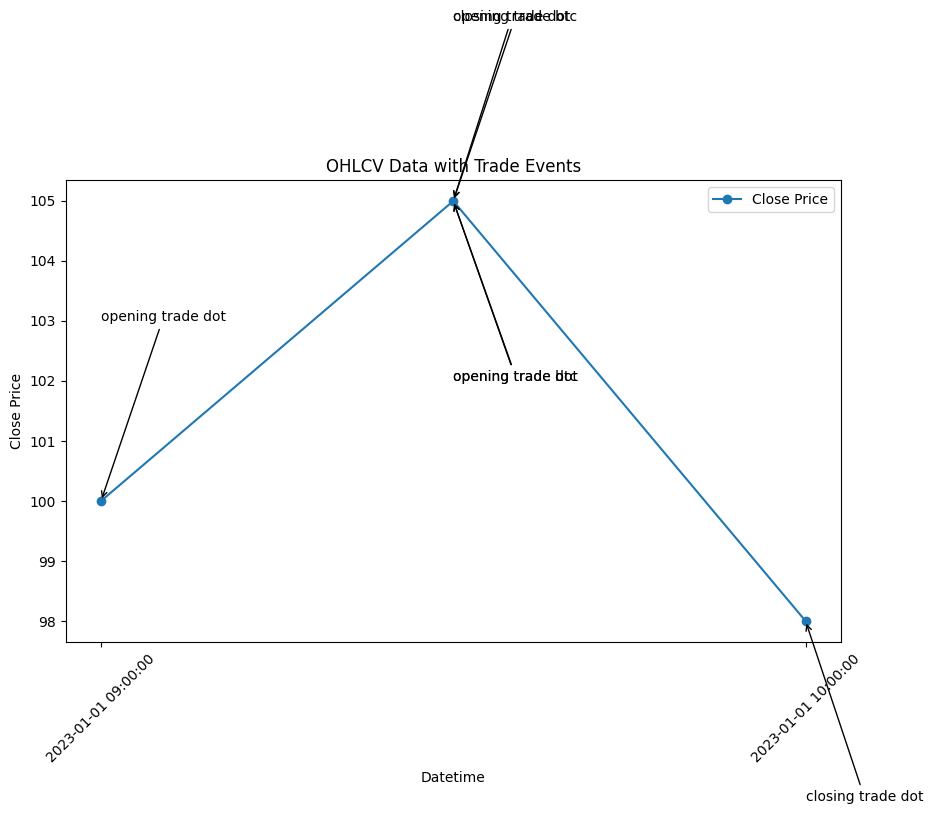

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Sample OHLCV data
datetime_list = ["2023-01-01 09:00:00", "2023-01-01 09:30:00", "2023-01-01 10:00:00"]
close_prices = [100, 105, 98]
trade_open_times = ["2023-01-01 09:15:00", "2023-01-01 09:30:00", "2023-01-01 09:45:00"]
trade_close_times = ["2023-01-01 09:30:00", "2023-01-01 09:45:00", "2023-01-01 10:15:00"]
trade_symbols = ["opening trade dot", "opening trade btc", "closing trade dot"]

# Convert strings to datetime objects
datetime_list = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in datetime_list]
trade_open_times = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in trade_open_times]
trade_close_times = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in trade_close_times]

# Plot OHLCV data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(datetime_list, close_prices, label='Close Price', marker='o', linestyle='-')

# Annotate trade events with different symbols on the line
for time, symbol in zip(trade_open_times, trade_symbols):
    closest_time = min(datetime_list, key=lambda x: abs(x - time))
    index = datetime_list.index(closest_time)
    ax.annotate(f'{symbol}', xy=(closest_time, close_prices[index]),
                xytext=(closest_time, close_prices[index] + 3),
                arrowprops=dict(facecolor='g', arrowstyle='->'))

for time, symbol in zip(trade_close_times, trade_symbols):
    closest_time = min(datetime_list, key=lambda x: abs(x - time))
    index = datetime_list.index(closest_time)
    ax.annotate(f'{symbol}', xy=(closest_time, close_prices[index]),
                xytext=(closest_time, close_prices[index] - 3),
                arrowprops=dict(facecolor='r', arrowstyle='->'))

# Format x-axis as datetime
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)

# Display legend
ax.legend()

# Show the plot
plt.title('OHLCV Data with Trade Events')
plt.xlabel('Datetime')
plt.ylabel('Close Price')
plt.show()


In [48]:
import os
import pandas as pd
from datetime import datetime
from finta import TA
from datetime import datetime, timedelta

from investing_algorithm_framework import create_app, RESOURCE_DIRECTORY, App, TradingTimeFrame

app: App = create_app({RESOURCE_DIRECTORY: os.getcwd()})
to_timestamp = datetime(2023, 11, 12)
from_timestamp = to_timestamp - timedelta(days=600)
data = app.get_ohclv(market="bitvavo", symbol='BTC/EUR', time_frame=TradingTimeFrame.TWO_HOUR, from_timestamp=from_timestamp, to_timestamp=to_timestamp)

def is_crossover(df: pd.DataFrame, period_one, period_two, date_time = None):
    """
    Expect df to have columns: Date, ma_<period_one>, ma_<period_two>.
    With the given date time it will check if the ma_<period_one> is above the ma_<period_two>
    """
    df[f"ma_{period_one}_above_ma_{period_two}"] = (df[f"ma_{period_one}"] > df[f"ma_{period_two}"]).astype(int)
    df[f"ma_{period_one}_ma_{period_two}_crosses"] = df[f"ma_{period_one}_above_ma_{period_two}"].diff().astype('Int64')

    if date_time is None:
        filtered_df = df
    else:
        filtered_df = df[df['Date'] <= date_time]

    if filtered_df.empty:
        raise Exception(f"Could not find moving average data for date {date_time}")

    last_row = filtered_df.iloc[-1]
    return last_row[f"ma_{period_one}_ma_{period_two}_crosses"] != 0

def is_ma_above(df: pd.DataFrame, period_one, period_two, date_time = None):
    """
    Expect df to have columns: Date, ma_<period_one>, ma_<period_two>.
    With the given date time it will check if the ma_<period_one> is above the ma_<period_two>
    """
    # Filter rows with date less than or equal to the given datetime, if none take all rows
    if date_time is None:
        filtered_df = df
    else:
        filtered_df = df[df['Date'] <= date_time]

    if filtered_df.empty:
        raise Exception(f"Could not find moving average data for date {date_time}")

    last_row = filtered_df.iloc[-1]
    ma_one = last_row[f'ma_{period_one}']
    ma_two = last_row[f'ma_{period_two}']
    return ma_one > ma_two

def get_ma_above_range(ma_one: pd.DataFrame, ma_two: pd.DataFrame):
    return (ma_one > ma_two).astype(int)

def calculate_moving_average(data, period):
    structured_data = {
        'Date': [entry[0] for entry in data],
        'Close': [entry[4] for entry in data]
    }
    df = pd.DataFrame(structured_data)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')
    return df['Close'].rolling(window=period).mean()

structured_data = {
    'Date': [entry[0] for entry in data],
    'Close': [entry[4] for entry in data]
}
df = pd.DataFrame(structured_data)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df["ma_50"] = calculate_moving_average(data, 50)
df["ma_200"] = calculate_moving_average(data, 200)
print(is_ma_above(df, '50', '200'))
print(is_crossover(df, '50', '200', datetime(2023, 5, 24, 8, 0, 0)))
df["ma_50_above_ma_200"] = get_ma_above_range(df["ma_50"], df["ma_200"])
df["ma_50_ma_200_crosses"] = df["ma_50_above_ma_200"].diff().astype('Int64')
crossover_rows = df[(df["ma_50_ma_200_crosses"] != 0)][["Date", "ma_50_ma_200_crosses"]]

if is_crossover(df, '9', '50') and not is_ma_above(df, '50', '100') and not is_ma_above(df, '100', '200'):
    print("opening position")
elif is_crossover(df, '9', '200'):
    print("sell position")
# print(crossover_rows)

True
True


# Backtest with Backtrade

In [26]:
import backtrader as bt
from datetime import timedelta

class MyCSVData(bt.feeds.GenericCSVData):
    params = (
        ('datetime', 0),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 5),
        ('openinterest', -1),  # Set to -1 if not present
    )


from datetime import datetime, timedelta
import backtrader as bt

class MyStrategy(bt.Signal):
    params = (('period', 20), )

    def __init__(self):
        super().__init__()
        self.lines.signal = self.data - bt.Simp(period=self.p.period)



# class MyStrategy(bt.Strategy):
#     params = (
#         ('ma9_period', 9),
#         ('ma50_period', 50),
#         ('ma100_period', 100),
#         ('ma200_period', 200),
#         ('limit_order_size', 15),
#         ('run_limit', 50),
#         ('max_open_positions', 5),
#         ('run_interval', 60 * 60),  # 1 hour in seconds
#         ('start_datetime', '2023-09-23 18:03'),
#     )
#
#     def __init__(self):
#         self.runs = 0
#         self.open_positions = 0
#         self.last_run_time = None
#
#         # Create moving averages
#         self.ma9 = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.ma9_period)
#         self.ma50 = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.ma50_period)
#         self.ma100 = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.ma100_period)
#         self.ma200 = bt.indicators.SimpleMovingAverage(self.data.close, period=self.params.ma200_period)
#
#     def next(self):
#         # Check if it's time for a new run
#         if self.last_run_time is None or self.data.datetime.datetime() >= self.last_run_time + timedelta(seconds=self.params.run_interval):
#             self.last_run_time = self.data.datetime.datetime()
#             self.runs += 1
#
#             # Check strategy conditions for buying
#             if (
#                 self.ma9 > self.ma50 and
#                 self.ma50 < self.ma100 and
#                 self.ma100 < self.ma200 and
#                 self.open_positions < self.params.max_open_positions
#             ):
#                 # Place Buy Order
#                 self.buy(size=self.params.limit_order_size)
#
#             # Check strategy conditions for selling
#             if (
#                 self.open_positions > 0 and
#                 self.ma9 > self.ma200
#             ):
#                 # Place Sell Order
#                 self.sell(size=self.position.size)
#
#             # Check if the maximum number of runs has been reached
#             if self.runs >= self.params.run_limit:
#                 self.env.runstop()
#
#     # def notify_order(self, order):
#     #     return order.Completed
#         # if order.status in [order.Completed, order.Canceled, order.Margin]:
#         #     return order.
cerebro = bt.Cerebro()

# Add data feed here (replace with your actual data)
data = MyCSVData(dataname='backtest_data/OHCLV_BTC-EUR_TWOHOUR_2022-11-03:00:00_2023-11-12:00:00.csv', dtformat='%Y-%m-%d %H:%M:%S')
cerebro.adddata(data)
cerebro.addstrategy(MyStrategy)
start_date = datetime(2023, 10, 20)

# Set start date and time
cerebro.run(runonce=False, stdstats=False, fromdate="2023-11-03")
cerebro.plot()


AttributeError: 'Lines_LineSeries_LineIterator_DataAccessor_Indicat' object has no attribute '_settz'

In [37]:
from backtesting import Strategy, Backtest
from backtesting.lib import crossover
from backtesting.test import SMA

BTCUSDT = pd.read_csv(
    'backtest_data/OHCLV_BTC-EUR_TWOHOUR_2022-11-03:00:00_2023-11-12:00:00.csv',
    index_col=0, parse_dates=True, infer_datetime_format=True
)

class SmaCross(Strategy):
    n1 = 10
    n2 = 100

    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, self.n1)
        self.ma2 = self.I(SMA, price, self.n2)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1) and self.position.pl > 0:
            self.sell()

bt = Backtest(
    BTCUSDT,
    SmaCross,
    commission=.002,
    exclusive_orders=True,
    cash=1000
)

output = bt.run()
print(output)
bt.plot()


/var/folders/_j/860z6kbj06dgbn5sdxynbkvr0000gn/T/ipykernel_44421/892320416.py:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  BTCUSDT = pd.read_csv(
/var/folders/_j/860z6kbj06dgbn5sdxynbkvr0000gn/T/ipykernel_44421/892320416.py:25: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(
/Users/marcvanduyn/Projects/LogicFunds/investing-algorithm-framework/venv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/marcvanduyn/Projects/L

Start                     2022-11-03 02:00:00
End                       2023-11-19 22:00:00
Duration                    381 days 20:00:00
Exposure Time [%]                         0.0
Equity Final [$]                       1000.0
Equity Peak [$]                        1000.0
Return [%]                                0.0
Buy & Hold Return [%]               66.157047
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

GridPlot(id='p3095', ...)

In [32]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class SmaCross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(SMA, price, 10)
        self.ma2 = self.I(SMA, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(GOOG, SmaCross, commission=.002,
              exclusive_orders=True)
stats = bt.run()
print(stats)
bt.plot()

Start                     2004-08-19 00:00:00
End                       2013-03-01 00:00:00
Duration                   3116 days 00:00:00
Exposure Time [%]                   97.067039
Equity Final [$]                  68221.96986
Equity Peak [$]                   68991.21986
Return [%]                         582.219699
Buy & Hold Return [%]              703.458242
Return (Ann.) [%]                   25.266427
Volatility (Ann.) [%]               38.383008
Sharpe Ratio                         0.658271
Sortino Ratio                        1.288779
Calmar Ratio                         0.763748
Max. Drawdown [%]                  -33.082172
Avg. Drawdown [%]                   -5.581506
Max. Drawdown Duration      688 days 00:00:00
Avg. Drawdown Duration       41 days 00:00:00
# Trades                                   94
Win Rate [%]                        54.255319
Best Trade [%]                       57.11931
Worst Trade [%]                    -16.629898
Avg. Trade [%]                    

/Users/marcvanduyn/Projects/LogicFunds/investing-algorithm-framework/venv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/marcvanduyn/Projects/LogicFunds/investing-algorithm-framework/venv/lib/python3.9/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/marcvanduyn/Projects/LogicFunds/investing-algorithm-framework/venv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/Users/marcvanduyn/Projects/LogicFunds/investing-algorithm-framework/venv/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning: found mul

GridPlot(id='p1989', ...)